#목차

0. 라이브러리 및 데이터 임포트
<br> 0.1. 코드프로그레션 전처리
<br> 0.2. 고유한 코드 목록
<br> 0.3. 고유한 키 목록
1. 으뜸음 통일
<br> 1.1. 으뜸음 변경할 데이터프레임만 분리
<br> 1.2. 으뜸음의 매핑 테이블과 으뜸음 변경 함수 정의
<br> 1.3. 으뜸음 변경
2. Signature 매핑 (Wongsaroj et al., 2014)
<br> 2.1. 코드를 인덱스의 리스트로 변환
<br> 2.2. 인덱스 리스트를 시그니처로 변환
3. 대안적 매핑 (자체 개발 CT 매핑)
<br> 3.1. 매핑 테이블과 매핑 함수 정의
<br> 3.2. 대안 매핑 적용
4. 코드 프로그레션 시각화
<br> 4.1. Signature 매핑에 따른 시각화
<br> 4.2. 대안적 매핑에 따른 시각화 
5. 박자 그룹별 코드프로그레션 시각화 저장
<br> 5.1. 3/4 박자 : Signature 매핑, 대안적 매핑
<br> 5.2. 4/4 박자 : Signature 매핑, 대안적 매핑
<br> 5.3. 6/8 박자 : Signature 매핑, 대안적 매핑
6. CNN : 이미지 간의 거리 측정
<br> 6.1. 3/4 박자 : Signature 매핑, 대안적 매핑
<br> 6.2. 4/4 박자 : Signature 매핑, 대안적 매핑
<br> 6.3. 6/8 박자 : Signature 매핑, 대안적 매핑
7. Signature 매핑과 대안적 매핑의 비교

#0 라이브러리 및 데이터 임포트

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.special
from google.colab import drive
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image

In [ ]:
data = pd.read_csv('commu_meta.csv')
data

,Unnamed: 0,audio_key,chord_progressions,pitch_range,num_measures,bpm,genre,track_role,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id
0,0,aminor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",mid,8,120,cinematic,main_melody,string_ensemble,standard,4/4,101,102,train,commu00001
1,1,cmajor,"[['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Dm'...",mid_low,8,80,newage,accompaniment,acoustic_piano,standard,4/4,23,30,train,commu00002
2,2,aminor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",mid_high,8,150,cinematic,riff,string_violin,standard,4/4,123,127,train,commu00003
3,3,cmajor,"[['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Gm'...",mid,8,110,cinematic,pad,choir,standard,4/4,45,46,train,commu00004
4,4,aminor,"[['Am', 'Am', 'Am', 'Am', 'Em', 'Em', 'Em', 'E...",mid_low,4,60,cinematic,pad,acoustic_piano,standard,4/4,21,22,train,commu00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,11139,cmajor,"[['Fmaj7', 'Fmaj7', 'Fmaj7', 'Fmaj7', 'Fmaj7',...",mid_high,8,110,cinematic,pad,synth_pad,standard,4/4,83,84,val,commu11140
11140,11140,cmajor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",mid_low,8,110,cinematic,riff,acoustic_guitar,standard,4/4,51,55,val,commu11141
11141,11141,aminor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",very_low,8,145,cinematic,bass,string_ensemble,standard,4/4,109,112,val,commu11142
11142,11142,aminor,"[['Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'A...",low,8,140,cinematic,accompaniment,string_cello,standard,4/4,55,115,val,commu11143


##0.1. 코드 프로그레이션 전처리
str type인 코드 프로그레션을 list로 변환

In [ ]:
temp = []
for k in data['chord_progressions']:
  temp.append(k.replace("'", "")[2:-2].split(', '))
data['chord_progressions'] = temp

In [ ]:
data['chord_progressions']

0        [Am, Am, Am, Am, Am, Am, Am, Am, C, C, C, C, C...
1        [C, C, C, C, C, C, C, C, Dm, Dm, Dm, Dm, Dm, D...
2        [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
3        [C, C, C, C, C, C, C, C, Gm, Gm, Gm, Gm, Gm, G...
4        [Am, Am, Am, Am, Em, Em, Em, Em, F, F, F, F, F...
                               ...                        
11139    [Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fma...
11140    [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
11141    [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
11142    [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
11143    [Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...
Name: chord_progressions, Length: 11144, dtype: object

##0.2. 고유한 코드 목록
코드를 signature로 매핑하기 위한 예비 단계

In [ ]:
chordlist = []
for i in data['chord_progressions']:
 chordlist += i

chordset = sorted(list(set(chordlist)))
print(chordset)
print(len(chordset)) 

['A', 'A#', 'A#7', 'A#m', 'A#maj7', 'A7', 'Adim', 'Am', 'Am7', 'Amaj7', 'Asus4', 'B', 'B7', 'Bdim', 'Bm7', 'Bm7b5', 'C', 'C#', 'C#+', 'C#m', 'C#maj7', 'C+', 'C7', 'Cm', 'Cm7', 'Cmaj7', 'Csus4', 'D', 'D#', 'D#+', 'D#dim', 'D#maj7', 'D7', 'Dm', 'Dm7', 'Dm7b5', 'Dmaj7', 'Dsus4', 'E', 'E+', 'E7', 'Em', 'Em7', 'Emaj7', 'Esus4', 'F', 'F#m7', 'F#m7b5', 'F7', 'Fm', 'Fm7', 'Fmaj7', 'G', 'G#dim', 'G#maj7', 'G+', 'G7', 'Gm', 'Gm7', 'Gmaj7', 'Gsus4']
61


In [ ]:
chordlist

['A',
 'A#',
 'A#7',
 'A#m',
 'A#maj7',
 'A7',
 'Adim',
 'Am',
 'Am7',
 'Amaj7',
 'Asus4',
 'B',
 'B7',
 'Bdim',
 'Bm7',
 'Bm7b5',
 'C',
 'C#',
 'C#+',
 'C#m',
 'C#maj7',
 'C+',
 'C7',
 'Cm',
 'Cm7',
 'Cmaj7',
 'Csus4',
 'D',
 'D#',
 'D#+',
 'D#dim',
 'D#maj7',
 'D7',
 'Dm',
 'Dm7',
 'Dm7b5',
 'Dmaj7',
 'Dsus4',
 'E',
 'E+',
 'E7',
 'Em',
 'Em7',
 'Emaj7',
 'Esus4',
 'F',
 'F#m7',
 'F#m7b5',
 'F7',
 'Fm',
 'Fm7',
 'Fmaj7',
 'G',
 'G#dim',
 'G#maj7',
 'G+',
 'G7',
 'Gm',
 'Gm7',
 'Gmaj7',
 'Gsus4']

##0.3. 고유한 키 목록
key의 통일을 위해 고유한 key 목록을 확인

In [ ]:
data['audio_key'].value_counts()

cmajor    6947
aminor    4197
Name: audio_key, dtype: int64

#1 으뜸음 통일
서로 다른 key들을 모두 Cmajor로 통일한다. <br>
Commu data에서는 Cmajor와 Aminor뿐이므로 Aminor을 Cminor로 바꾼다

##1.1. 으뜸음 변경할 데이터프레임만 분리

In [ ]:
#으뜸음을 바꿔줄 데이터프레임은 key가 Aminor인 경우

data_norm = data[:] 
aminors = data_norm[data_norm['audio_key'] == 'aminor']

In [ ]:
#Aminor인 샘플들의 고유한 chord들 취합

chordlist_a = [] 
for i in aminors['chord_progressions']:
 chordlist_a += i

chordlist_a = sorted(list(set(chordlist_a)))
print(chordlist_a)
print(len(set(chordlist_a))) 

['A', 'A#', 'A#m', 'A#maj7', 'A7', 'Adim', 'Am', 'Am7', 'Amaj7', 'Asus4', 'B', 'B7', 'Bdim', 'Bm7b5', 'C', 'C#m', 'C#maj7', 'Cm', 'Cmaj7', 'D', 'D#maj7', 'D7', 'Dm', 'Dm7', 'Dmaj7', 'Dsus4', 'E', 'E+', 'E7', 'Em', 'Em7', 'Emaj7', 'Esus4', 'F', 'F#m7', 'F#m7b5', 'Fm', 'Fmaj7', 'G', 'G#dim', 'G7', 'Gmaj7', 'Gsus4']
43


##1.2. 으뜸음의 매핑 테이블과 으뜸음 변경 함수 정의

In [ ]:
#으뜸음의 매핑 테이블: 이 매핑 테이블을 참조하여 으뜸음 변환

a_to_c_map = pd.DataFrame({'list_a':['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'], 'list_c':['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']}) 
a_to_c_map

,list_a,list_c
0,A,C
1,A#,C#
2,B,D
3,C,D#
4,C#,E
5,D,F
6,D#,F#
7,E,G
8,F,G#
9,F#,A


In [ ]:
#매핑테이블에 기반해 Aminor key 하에서의 코드들을 Cmajor key 하에서의 코드들로 변환하는 함수

def a_to_c(a, map): 
  try:
    if a[1] == '#':
      new = list(map[map['list_a'] == a[:2]]['list_c'])[0]
      a = a.replace(a[:2], new)
    else:
      new = list(map[map['list_a'] == a[0]]['list_c'])[0]
      a = a.replace(a[0], new)
  except:
    new = list(map[map['list_a'] == a[0]]['list_c'])[0]
    a = a.replace(a[0], new)
  return a

In [ ]:
#위의 함수를 적용해 Aminor key에서의 코드들을 Cmajor key에서의 코드들로 바꾸는 매핑테이블

temp = []
for i in chordlist_a:
  temp.append(a_to_c(i, a_to_c_map))

keymap = pd.DataFrame({'key=Aminor': chordlist_a, 'key=Cmajor':temp})
keymap

,key=Aminor,key=Cmajor
0,A,C
1,A#,C#
2,A#m,C#m
3,A#maj7,C#maj7
4,A7,C7
5,Adim,Cdim
6,Am,Cm
7,Am7,Cm7
8,Amaj7,Cmaj7
9,Asus4,Csus4


In [ ]:
#주어진 코드프로그레션을 keymap에 기반해서 변환해주는 함수

def normalize_key(chord_progression, map):
  temp = []
  for i in chord_progression:
    norm = list(map[map['key=Aminor'] == i]['key=Cmajor'])[0]
    temp.append(norm)
  return temp

##1.3. 으뜸음 변경

In [ ]:
#작성한 함수를 통해 으뜸음 변환

temp = []
for progression in aminors['chord_progressions']:  
  a = normalize_key(progression, keymap)
  temp.append(a)
  if len(temp) % 100 == 0: #진행률
    print(len(temp)/len(aminors))
  else:
    pass

aminors['chord_progressions'] = temp

0.02382654276864427
0.04765308553728854
0.07147962830593281
0.09530617107457708
0.11913271384322136
0.14295925661186562
0.16678579938050989
0.19061234214915415
0.21443888491779842
0.2382654276864427
0.262091970455087
0.28591851322373124
0.3097450559923755
0.33357159876101977
0.35739814152966404
0.3812246842983083
0.40505122706695257
0.42887776983559683
0.4527043126042411
0.4765308553728854
0.5003573981415297
0.524183940910174
0.5480104836788182
0.5718370264474625
0.5956635692161067
0.619490111984751
0.6433166547533953
0.6671431975220395
0.6909697402906838
0.7147962830593281
0.7386228258279723
0.7624493685966166
0.7862759113652609
0.8101024541339051
0.8339289969025494
0.8577555396711937
0.8815820824398379
0.9054086252084822
0.9292351679771265
0.9530617107457708
0.9768882535144151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
#Cmajor인 데이터프레임과 concat

cmajors = data_norm[data_norm['audio_key'] == 'cmajor']
mydata = pd.concat([aminors, cmajors]).sort_values(by = ['Unnamed: 0'])

In [ ]:
mydata

,Unnamed: 0,audio_key,chord_progressions,pitch_range,num_measures,bpm,genre,track_role,inst,sample_rhythm,time_signature,min_velocity,max_velocity,split_data,id
0,0,aminor,"[Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, D#, D#, D#, D...",mid,8,120,cinematic,main_melody,string_ensemble,standard,4/4,101,102,train,commu00001
1,1,cmajor,"[C, C, C, C, C, C, C, C, Dm, Dm, Dm, Dm, Dm, D...",mid_low,8,80,newage,accompaniment,acoustic_piano,standard,4/4,23,30,train,commu00002
2,2,aminor,"[Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, C...",mid_high,8,150,cinematic,riff,string_violin,standard,4/4,123,127,train,commu00003
3,3,cmajor,"[C, C, C, C, C, C, C, C, Gm, Gm, Gm, Gm, Gm, G...",mid,8,110,cinematic,pad,choir,standard,4/4,45,46,train,commu00004
4,4,aminor,"[Cm, Cm, Cm, Cm, Gm, Gm, Gm, Gm, G#, G#, G#, G...",mid_low,4,60,cinematic,pad,acoustic_piano,standard,4/4,21,22,train,commu00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,11139,cmajor,"[Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fmaj7, Fma...",mid_high,8,110,cinematic,pad,synth_pad,standard,4/4,83,84,val,commu11140
11140,11140,cmajor,"[Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, A...",mid_low,8,110,cinematic,riff,acoustic_guitar,standard,4/4,51,55,val,commu11141
11141,11141,aminor,"[Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, C...",very_low,8,145,cinematic,bass,string_ensemble,standard,4/4,109,112,val,commu11142
11142,11142,aminor,"[Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, C...",low,8,140,cinematic,accompaniment,string_cello,standard,4/4,55,115,val,commu11143


In [ ]:
data = mydata

#2 Signature 매핑 (Wongsaroj et al., 2014)

##2.1. 코드를 인덱스의 리스트로 변환

In [ ]:
#근음과 구성음을 애들을 분리해서 딕셔너리로 만들기

base = {"C":0, "C#":1, "D":2, "D#":3, "E":4, "F":5, "F#":6, "G":7,
        "G#":8, "A":9, "A#":10, "B":11}

chord_dict = {"":  [0, 4, 7], "m": [0, 3, 7], "+": [0, 4, 8], "7": [0, 4, 7, 10],
              "maj7": [0, 4, 7, 11], "m7": [0, 3, 7, 10],
              "sus4": [0, 5, 7], "dim": [0, 3, 6],
              "m7b5": [0, 3, 6, 10]} #""는 major를 의미하며 C근음일 때의 구성음에 해당하는 리스트들임

In [ ]:
#주어진 코드를 위의 딕셔너리를 참고하여 인덱스 리스트로 바꾸는 함수

def numbering(chord, basedict, chorddict):
  try: #여기서 에러나면 코드이름의 길이가 1인 것. 예를 들어 C, F, G 
    if chord[1] == '#': #만약 근음에 #이 포함되면
      base = basedict[chord[:2]] # x#까지 포함한 것을 근음으로 받아들여서 해당하는 인덱스를 딕셔너리를 참조해서 부여
      nonbase = chorddict[chord[2:]] #근음 뒤부터는 구성음으로 받아들여서 해당하는 인덱스 리스트를 딕셔너리를 참조해서 부여. 이때 부여된 인덱스들은 C근음 기준
      pitches = list(base + np.array(nonbase)) #C근음이 기준인 인덱스 리스트에 실제 근음을 더하면 실제 근음에 해당하는 인덱스 리스트로 바뀜
      result = []
      for pitch in pitches: #만약 실제 근음을 더했을 때 인덱스 리스트에 11을 넘는 값이 생기면 12를 빼기
        if pitch > 11:
          result.append(pitch - 12) 
        else:
          result.append(pitch)
      return result
    else: #근음에 #이 포함이 안 돼있는 경우: 위와 동일한 과정
      base = basedict[chord[0]]
      nonbase = chorddict[chord[1:]]
      pitches = list(base + np.array(nonbase))
      result = []
      for pitch in pitches:
        if pitch > 11:
          result.append(pitch - 12)
        else:
          result.append(pitch)
      return result
  except: #코드 이름의 길이가 1 이상인 경우: 위와 동일한 과정
      base = basedict[chord[0]] 
      nonbase = chorddict[chord[1:]]
      pitches = list(base + np.array(nonbase))
      result = []
      for pitch in pitches:
        if pitch > 11:
          result.append(pitch - 12)
        else:
          result.append(pitch)
      return result

In [ ]:
#위 함수와 딕셔너리를 참조하여 고유한 코드 리스트에 담긴 코드들을 인덱스의 리스트로 바꾸기

for chord in chordlist:
  print('{0} : '.format(chord), numbering(chord, base, chord_dict))

A :  [9, 1, 4]
A# :  [10, 2, 5]
A#7 :  [10, 2, 5, 8]
A#maj7 :  [10, 2, 5, 9]
A#sus4 :  [10, 3, 5]
A7 :  [9, 1, 4, 7]
Adim :  [9, 0, 3]
Am :  [9, 0, 4]
Am7 :  [9, 0, 4, 7]
Am7b5 :  [9, 0, 3, 7]
Asus4 :  [9, 2, 4]
B :  [11, 3, 6]
B7 :  [11, 3, 6, 9]
Bdim :  [11, 2, 5]
Bm7 :  [11, 2, 6, 9]
Bm7b5 :  [11, 2, 5, 9]
C :  [0, 4, 7]
C# :  [1, 5, 8]
C#+ :  [1, 5, 9]
C#m :  [1, 4, 8]
C#maj7 :  [1, 5, 8, 0]
C+ :  [0, 4, 8]
C7 :  [0, 4, 7, 10]
Cdim :  [0, 3, 6]
Cm :  [0, 3, 7]
Cm7 :  [0, 3, 7, 10]
Cmaj7 :  [0, 4, 7, 11]
Csus4 :  [0, 5, 7]
D :  [2, 6, 9]
D# :  [3, 7, 10]
D#+ :  [3, 7, 11]
D#dim :  [3, 6, 9]
D#m :  [3, 6, 10]
D#maj7 :  [3, 7, 10, 2]
D7 :  [2, 6, 9, 0]
Ddim :  [2, 5, 8]
Dm :  [2, 5, 9]
Dm7 :  [2, 5, 9, 0]
Dm7b5 :  [2, 5, 8, 0]
Dmaj7 :  [2, 6, 9, 1]
Dsus4 :  [2, 7, 9]
E :  [4, 8, 11]
E+ :  [4, 8, 0]
E7 :  [4, 8, 11, 2]
Em :  [4, 7, 11]
Em7 :  [4, 7, 11, 2]
Emaj7 :  [4, 8, 11, 3]
Esus4 :  [4, 9, 11]
F :  [5, 9, 0]
F#m7b5 :  [6, 9, 0, 4]
F#maj7 :  [6, 10, 1, 5]
F7 :  [5, 9, 0, 3]
Fm :  [

##2.2. 인덱스 리스트를 시그니처로 변환

In [ ]:
#주어진 인덱스 리스트를 시그니처로 변환하는 함수

def signature(pitches):
  signature = []
  for pitch in pitches:
    signature.append(2**pitch) #시그니쳐 계산식: 2의 인덱스 승의 summation
  return sum(signature)

In [ ]:
#위 함수를 적용하여 각 코드들을 시그니처로 매핑

for chord in chordlist:
  print('{0} : '.format(chord), signature(numbering(chord, base, chord_dict)))

A :  530
A# :  1060
A#7 :  1316
A#maj7 :  1572
A#sus4 :  1064
A7 :  658
Adim :  521
Am :  529
Am7 :  657
Am7b5 :  649
Asus4 :  532
B :  2120
B7 :  2632
Bdim :  2084
Bm7 :  2628
Bm7b5 :  2596
C :  145
C# :  290
C#+ :  546
C#m :  274
C#maj7 :  291
C+ :  273
C7 :  1169
Cdim :  73
Cm :  137
Cm7 :  1161
Cmaj7 :  2193
Csus4 :  161
D :  580
D# :  1160
D#+ :  2184
D#dim :  584
D#m :  1096
D#maj7 :  1164
D7 :  581
Ddim :  292
Dm :  548
Dm7 :  549
Dm7b5 :  293
Dmaj7 :  582
Dsus4 :  644
E :  2320
E+ :  273
E7 :  2324
Em :  2192
Em7 :  2196
Emaj7 :  2328
Esus4 :  2576
F :  545
F#m7b5 :  593
F#maj7 :  1122
F7 :  553
Fm :  289
Fm7 :  297
Fmaj7 :  561
Fsus4 :  1057
G :  2180
G# :  265
G#m :  2312
G#maj7 :  393
G+ :  2184
G7 :  2212
Gm :  1156
Gm7 :  1188
Gmaj7 :  2244
Gsus4 :  133


In [ ]:
#주어진 코드프로그레션을 시그니처 프로그레션으로 바꾸는 함수

def signature_progression(chord_progression):
  temp = []
  for chord in chord_progression:
    temp.append(signature(numbering(chord, base, chord_dict)))
  return temp

In [ ]:
#위 함수를 적용하여 실제 데이터 프레임의 코드 프로그레션을 시그니처 프로그레션으로 변환

temp = []
for chord_progression in data['chord_progressions']:
  temp.append(signature_progression(chord_progression))

data['signature_progressions'] = temp

In [ ]:
data['signature_progressions']

0        [137, 137, 137, 137, 137, 137, 137, 137, 1160,...
1        [145, 145, 145, 145, 145, 145, 145, 145, 548, ...
2        [137, 137, 137, 137, 137, 137, 137, 137, 137, ...
3        [145, 145, 145, 145, 145, 145, 145, 145, 1156,...
4        [137, 137, 137, 137, 1156, 1156, 1156, 1156, 2...
                               ...                        
11139    [561, 561, 561, 561, 561, 561, 561, 561, 2196,...
11140    [529, 529, 529, 529, 529, 529, 529, 529, 529, ...
11141    [137, 137, 137, 137, 137, 137, 137, 137, 137, ...
11142    [137, 137, 137, 137, 137, 137, 137, 137, 137, ...
11143    [137, 137, 137, 137, 137, 137, 137, 137, 137, ...
Name: signature_progressions, Length: 11144, dtype: object

#3 대안적 매핑 (자체 개발 CT 매핑)

##3.1. 매핑 테이블과 매핑 함수 정의

In [ ]:
new_map = pd.read_excel('new_chords_mj.xlsx')

In [ ]:
new_map #새로운 매핑 테이블: root과 type은 근음과 구성음. chord는 코드, result는 코드에 대응하는 매핑값

,root,type,chords,result
0,Cb,NaN,Cb,1200
1,Cb,maj7,Cbmaj7,1205
2,Cb,7,Cb7,1210
3,Cb,sus4,Cbsus4,1215
4,Cb,+,Cb+,1220
...,...,...,...,...
184,B#,+,B#+,120
185,B#,m,B#m,125
186,B#,m7,B#m7,130
187,B#,dim,B#dim,135


In [ ]:
#주어진 코드를 위의 딕셔너리를 참고하여 실수로 매핑하는 함수

def numbering_new(chord, new_map):
  result = int(list(new_map[new_map['chords'] == chord]['result'])[0])
  return result

In [ ]:
for chord in chordlist:
  print('{0} : '.format(chord), numbering_new(chord, new_map))

A :  1000
A# :  1100
A#7 :  1110
A#maj7 :  1105
A#sus4 :  1115
A7 :  1010
Adim :  1035
Am :  1025
Am7 :  1030
Am7b5 :  1040
Asus4 :  1015
B :  1200
B7 :  1210
Bdim :  1235
Bm7 :  1230
Bm7b5 :  1240
C :  100
C# :  200
C#+ :  220
C#m :  225
C#maj7 :  205
C+ :  120
C7 :  110
Cdim :  135
Cm :  125
Cm7 :  130
Cmaj7 :  105
Csus4 :  115
D :  300
D# :  400
D#+ :  420
D#dim :  435
D#m :  425
D#maj7 :  405
D7 :  310
Ddim :  335
Dm :  325
Dm7 :  330
Dm7b5 :  340
Dmaj7 :  305
Dsus4 :  315
E :  500
E+ :  520
E7 :  510
Em :  525
Em7 :  530
Emaj7 :  505
Esus4 :  515
F :  600
F#m7b5 :  740
F#maj7 :  705
F7 :  610
Fm :  625
Fm7 :  630
Fmaj7 :  605
Fsus4 :  615
G :  800
G# :  900
G#m :  925
G#maj7 :  905
G+ :  820
G7 :  810
Gm :  825
Gm7 :  830
Gmaj7 :  805
Gsus4 :  815


##3.2. 대안 매핑 적용

In [ ]:
#주어진 코드프로그레션을 대안매핑-프로그레션(CT 프로그레션)으로 바꾸는 함수

def ct_progression(chord_progression):
  temp = []
  for chord in chord_progression:
    temp.append(numbering_new(chord, new_map))
  return temp

In [ ]:
#위 함수를 적용하여 실제 데이터프레임의 코드프로그레션을 변환

temp = []
for i, chord_progression in enumerate(data['chord_progressions']):
  temp.append(ct_progression(chord_progression))
  print((i/len(data)))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0.5513280689160086
0.5514178033022255
0.5515075376884422
0.551597272074659
0.5516870064608758
0.5517767408470926
0.5518664752333095
0.5519562096195262
0.552045944005743
0.5521356783919598
0.5522254127781766
0.5523151471643934
0.5524048815506102
0.552494615936827
0.5525843503230438
0.5526740847092606
0.5527638190954773
0.5528535534816942
0.552943287867911
0.5530330222541278
0.5531227566403446
0.5532124910265613
0.5533022254127782
0.553391959798995
0.5534816941852118
0.5535714285714286
0.5536611629576453
0.5537508973438622
0.5538406317300789
0.5539303661162958
0.5540201005025126
0.5541098348887293
0.5541995692749462
0.5542893036611629
0.5543790380473798
0.5544687724335966
0.5545585068198133
0.5546482412060302
0.5547379755922469
0.5548277099784638
0.5549174443646806
0.5550071787508973
0.5550969131371142
0.5551866475233309
0.5552763819095478
0.5553661162957645
0.5554558506819813
0.5555455850681982
0.5556353194544149
0.5557250538406318
0.5558147882268485


In [ ]:
data['ct_progressions'] = temp

In [ ]:
data['ct_progressions']

0        [125, 125, 125, 125, 125, 125, 125, 125, 400, ...
1        [100, 100, 100, 100, 100, 100, 100, 100, 325, ...
2        [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
3        [100, 100, 100, 100, 100, 100, 100, 100, 825, ...
4        [125, 125, 125, 125, 825, 825, 825, 825, 900, ...
                               ...                        
11139    [605, 605, 605, 605, 605, 605, 605, 605, 530, ...
11140    [1025, 1025, 1025, 1025, 1025, 1025, 1025, 102...
11141    [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
11142    [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
11143    [125, 125, 125, 125, 125, 125, 125, 125, 125, ...
Name: mj_progressions, Length: 11144, dtype: object

#4 코드 프로그레션 시각화

##4.1. Signature 매핑에 따른 시각화

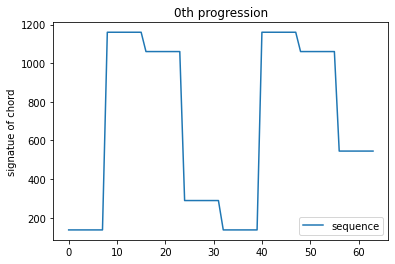

In [ ]:
num = 0
num

plt.plot(data['signature_progressions'][num], label = 'sequence')
plt.ylabel('signatue of chord')
plt.title('{}th progression'.format(num))
plt.legend()

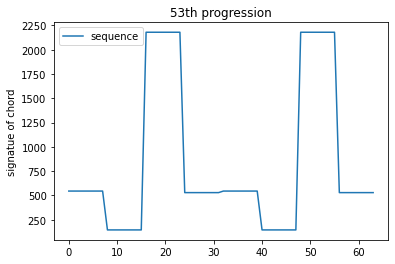

In [ ]:
num = 53
num

plt.plot(data['signature_progressions'][num], label = 'sequence')
plt.ylabel('signatue of chord')
plt.title('{}th progression'.format(num))
plt.legend()

##4.2. 대안적 매핑에 따른 시각화

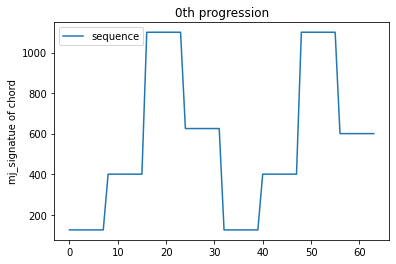

In [ ]:
num = 0
num

plt.plot(data['ct_progressions'][num], label = 'sequence')
plt.ylabel('ct_signatue of chord')
plt.title('{}th progression'.format(num))
plt.legend()

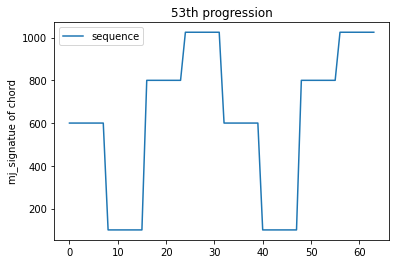

In [ ]:
num = 53
num

plt.plot(data['mj_progressions'][num], label = 'sequence')
plt.ylabel('mj_signatue of chord')
plt.title('{}th progression'.format(num))
plt.legend()

# 5. 박자 그룹별 코드프로그레션 시각화 저장
박자 그룹별로 두 가지 방식으로 시각화를 진행한 후 이미지로 저장

In [ ]:
# 박자별 데이터프레임 형성
data_3_4 = data[data.time_signature == '3/4']
data_4_4 = data[data.time_signature == '4/4']
data_6_8 = data[data.time_signature == '6/8']

## 3/4 박자(43개)

### Signature 매핑

In [ ]:
uni_prog_3_4 = [] # progression
uni_idx_3_4 = [] # index

for i in range(len(data_3_4)):
  chord = data_3_4['signature_progressions'].iloc[i]
  if chord not in uni_prog_3_4: 
    uni_prog_3_4.append(chord) # unique progression을 리스트에 추가
    uni_idx_3_4.append(data_3_4.index[i]) # unique progression의 인덱스 추가

In [ ]:
for i in range(len(uni_prog_3_4)): # img_{index}.jpg 형식으로 3/4 파일에 저장
  plt.figure()
  plt.plot(uni_prog_3_4[i])
  plt.savefig(f'./Image_3_4/img_{uni_idx_3_4[i]}.jpg')

### 대안적 매핑

In [ ]:
uni_prog_3_4_CT = []
uni_idx_3_4_CT = []

for i in range(len(data_3_4)):
  chord = data_3_4['ct_progressions'].iloc[i]
  if chord not in uni_prog_3_4_CT: 
    uni_prog_3_4_CT.append(chord) # unique progression을 리스트에 추가
    uni_idx_3_4_CT.append(data_3_4.index[i]) # unique progression의 인덱스 추가

In [ ]:
for i in range(len(uni_prog_3_4_CT)): # img_{index}.jpg 형식으로 3/4, CT 매핑 파일에 저장
  plt.figure()
  plt.plot(uni_prog_3_4_CT[i])
  plt.savefig(f'./Image_3_4_CT/img_{uni_idx_3_4_CT[i]}.jpg')

## 4/4 박자(241개)

### Signature 매핑

In [ ]:
uni_prog_4_4 = []
uni_idx_4_4 = []

for i in range(len(data_4_4)):
  chord = data_4_4['signature_progressions'].iloc[i]
  if chord not in uni_prog_4_4:
    uni_prog_4_4.append(chord)
    uni_idx_4_4.append(data_4_4.index[i])

In [ ]:
for i in range(len(uni_prog_4_4)):
  plt.figure()
  plt.plot(uni_prog_4_4[i])
  plt.savefig(f'./Image_4_4/img_{uni_idx_4_4[i]}.jpg')

### 대안적 매핑

In [ ]:
uni_prog_4_4_CT = []
uni_idx_4_4_CT = []

for i in range(len(data_4_4)):
  chord = data_4_4['ct_progressions'].iloc[i]
  if chord not in uni_prog_4_4_CT:
    uni_prog_4_4_CT.append(chord)
    uni_idx_4_4_CT.append(data_4_4.index[i])

In [ ]:
for i in range(len(uni_prog_4_4_CT)):
  plt.figure()
  plt.plot(uni_prog_4_4_CT[i])
  plt.savefig(f'./Image_4_4_CT/img_{uni_idx_4_4_CT[i]}.jpg')

## 6/8 박자

### Signature 매핑

In [ ]:
uni_prog_6_8 = []
uni_idx_6_8 = []

for i in range(len(data_6_8)):
  chord = data_6_8['signature_progressions'].iloc[i]
  if chord not in uni_prog_6_8:
    uni_prog_6_8.append(chord)
    uni_idx_6_8.append(data_6_8.index[i])

In [ ]:
for i in range(len(uni_prog_6_8)):
  plt.figure()
  plt.plot(uni_prog_6_8[i])
  plt.savefig(f'./Image_6_8/img_{uni_idx_6_8[i]}.jpg')

### 대안적 매핑

In [ ]:
uni_prog_6_8_CT = []
uni_idx_6_8_CT = []

for i in range(len(data_6_8)):
  chord = data_6_8['ct_progressions'].iloc[i]
  if chord not in uni_prog_6_8_CT:
    uni_prog_6_8_CT.append(chord)
    uni_idx_6_8_CT.append(data_6_8.index[i])

In [ ]:
for i in range(len(uni_prog_6_8_CT)):
  plt.figure()
  plt.plot(uni_prog_6_8_CT[i])
  plt.savefig(f'./Image_6_8_CT/img_{uni_idx_6_8_CT[i]}.jpg')

# 6. CNN : 이미지 간의 거리 측정
VGG-16 모델을 사용하여 이미지 간의 유사도 측정

In [ ]:
class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [ ]:
conv_base = VGG16(weights='imagenet')
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 3/4 박자

### Signature 매핑

In [ ]:
features = []
img_paths = []
fe = FeatureExtractor()

# Save Image Feature Vector with Database Images
for i in uni_idx_3_4:
  try:
    image_path = "./Image_3_4/img_" + str(i) + ".jpg" # 저장된 이미지의 경로를 img_paths 리스트에 저장
    img_paths.append(image_path)

    # Extract Features : impage_path에 따라 이미지를 열어 resize, convert 진행 및 feature 추출
    feature = fe.extract(img=Image.open(image_path))

    features.append(feature) # 추출된 feature를 리스트에 저장

    # Save the Numpy array (.npy) on designated path
    feature_path = "./Image_3_4/m/img_" + str(i) + ".npy" # numpy array 형태로 npy_3_4 파일에 저장
    np.save(feature_path, feature)
  except Exception as e:
    print('예외가 발생했습니다.', e)

1/1 [==============================] - 1s 595ms/step


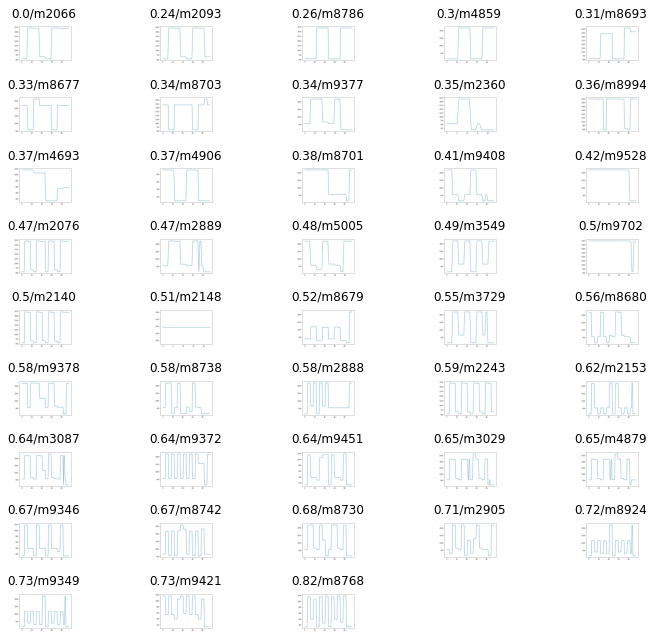

In [ ]:
# Insert the image query
img = Image.open("./Image_3_4/img_2066.jpg") # 거리 계산의 기준이 될 이미지 설정, 형식에 맞춰 변경 가능
# Extract its features
query = fe.extract(img) # 기준 이미지의 feature를 query에 저장

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis=1) # L2 norm 거리 계산

# Sort the id of images that have lowest distance
ids = np.argsort(dists) # 거리가 낮은 순서로 dists 인덱스를 리스트로 저장 

# Save the distance, image path, actual index
scores_3_4 = [(dists[id], img_paths[id], uni_idx_3_4[id]) for id in ids] 

# Visualize the result
axes=[]
fig=plt.figure(figsize=(10,10))
for a in range(len(uni_idx_3_4)):
    score = scores_3_4[a]
    axes.append(fig.add_subplot(10, 5, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2]) # 거리와 이미지 인덱스 제목으로 설정
    axes[-1].set_title(subplot_title)
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

In [ ]:
imgs_3_4 = []
dissims_3_4 = []

for i in scores_3_4: # 리스트에 저장된 인덱스, 거리(score)를 따로 리스트에 저장
  img = i[-1]
  dissim = i[0]
  imgs_3_4.append(img)
  dissims_3_4.append(dissim)

cs_3_4 = pd.DataFrame({'img':imgs_3_4, 'score':dissims_3_4}) 
cs_3_4['rank'] = cs_3_4['score'].rank(method = 'min') # score에 따라 순위 지정(동점인 경우 minimum)
cs_3_4 # 데이터프레임 형식으로 저장

,img,score,rank
0,2066,0.000000,1.0
1,2093,0.171169,2.0
2,2889,0.232331,3.0
3,5005,0.299810,4.0
4,8994,0.353693,5.0
5,3549,0.402621,6.0
6,3729,0.403773,7.0
7,9451,0.411864,8.0
8,9377,0.419554,9.0
9,9372,0.425751,10.0


### 대안적 매핑

In [ ]:
features = []
img_paths = []
fe = FeatureExtractor()

# Save Image Feature Vector with Database Images
for i in uni_idx_3_4_CT:
  try:
    image_path = "./Image_3_4_CT/img_" + str(i) + ".jpg"
    img_paths.append(image_path)

    # Extract Features
    feature = fe.extract(img=Image.open(image_path))

    features.append(feature)

    # Save the Numpy array (.npy) on designated path
    feature_path = "./Image_3_4_CT/m/img_" + str(i) + ".npy"
    np.save(feature_path, feature)
  except Exception as e:
    print('예외가 발생했습니다.', e)

1/1 [==============================] - 1s 582ms/step


1/1 [==============================] - 1s 605ms/step


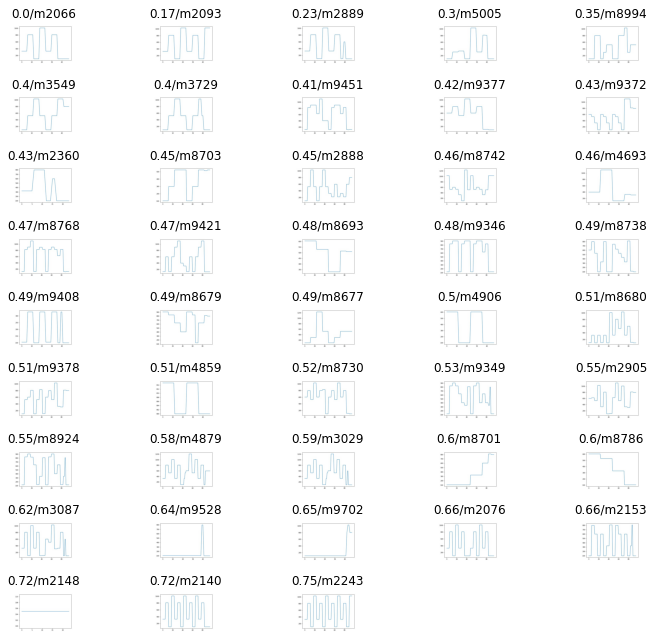

In [ ]:
# Insert the image query
img = Image.open("./Image_3_4_CT/img_2066.jpg")
# Extract its features
query = fe.extract(img)

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis=1)

# Sort the id of images that have lowest distance
ids = np.argsort(dists)

scores_3_4_CT = [(dists[id], img_paths[id], uni_idx_3_4_CT[id]) for id in ids]

# Visualize the result
axes=[]
fig=plt.figure(figsize=(10,10))
for a in range(len(uni_idx_3_4_CT)):
    score = scores_3_4_CT[a]
    axes.append(fig.add_subplot(10, 5, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

In [ ]:
imgs_3_4_CT = []
dissims_3_4_CT = []

for i in scores_3_4_CT:
  img = i[-1]
  dissim = i[0]
  imgs_3_4_CT.append(img)
  dissims_3_4_CT.append(dissim)

ct_3_4 = pd.DataFrame({'img':imgs_3_4_CT, 'score':dissims_3_4_CT}) 
ct_3_4['rank'] = ct_3_4['score'].rank(method = 'min')
ct_3_4

,img,score,rank
0,2066,0.000000,1.0
1,2093,0.171169,2.0
2,2889,0.232331,3.0
3,5005,0.299810,4.0
4,8994,0.353693,5.0
5,3549,0.402621,6.0
6,3729,0.403773,7.0
7,9451,0.411864,8.0
8,9377,0.419554,9.0
9,9372,0.425751,10.0


## 4/4 박자

### Signature 매핑

In [ ]:
features = []
img_paths = []
fe = FeatureExtractor()

# Save Image Feature Vector with Database Images
for i in uni_idx_4_4:
  try:
    image_path = "./Image_4_4/img_" + str(i) + ".jpg"
    img_paths.append(image_path)

    # Extract Features
    feature = fe.extract(img=Image.open(image_path))

    features.append(feature)

    # Save the Numpy array (.npy) on designated path
    feature_path = "./Image_4_4/m/img_" + str(i) + ".npy"
    np.save(feature_path, feature)
  except Exception as e:
    print('예외가 발생했습니다.', e)

1/1 [==============================] - 1s 727ms/step


1/1 [==============================] - 1s 596ms/step


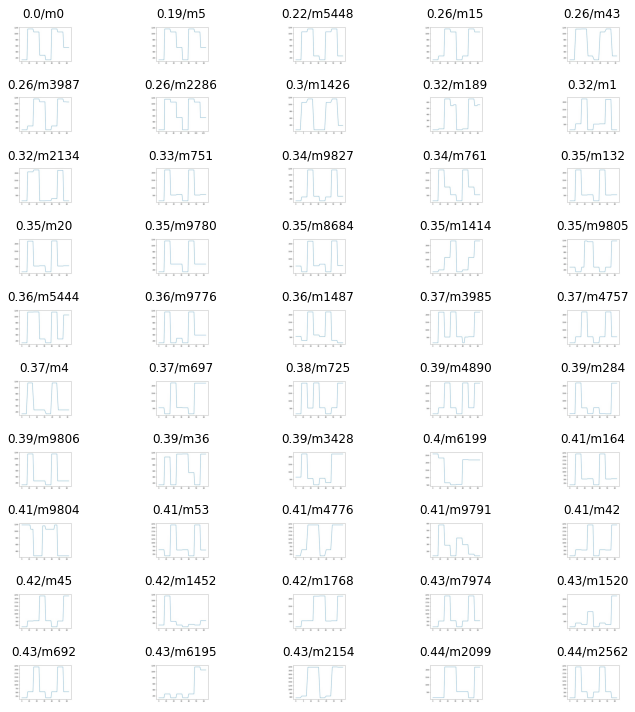

In [ ]:
# Insert the image query
img = Image.open("./Image_4_4/img_0.jpg")
# Extract its features
query = fe.extract(img)

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis=1)

# Sort the id of images that have lowest distance
ids = np.argsort(dists)

scores_4_4 = [(dists[id], img_paths[id], uni_idx_4_4[id]) for id in ids]

# Visualize the result
axes=[]
fig=plt.figure(figsize=(10,10))
for a in range(50): # 상위 50개만 추출
    score = scores_4_4[a]
    axes.append(fig.add_subplot(10, 5, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

In [ ]:
imgs_4_4 = []
dissims_4_4 = []

for i in scores_4_4:
  img = i[-1]
  dissim = i[0]
  imgs_4_4.append(img)
  dissims_4_4.append(dissim)

cs_4_4 = pd.DataFrame({'img':imgs_4_4, 'score':dissims_4_4}) 
cs_4_4['rank'] = cs_4_4['score'].rank(method = 'min')
cs_4_4

,img,score,rank
0,0,0.000000,1.0
1,5,0.187504,2.0
2,5448,0.221715,3.0
3,15,0.255373,4.0
4,43,0.258407,5.0
...,...,...,...
236,86,0.757732,237.0
237,6251,0.759276,238.0
238,5498,0.771659,239.0
239,1750,0.772115,240.0


### 대안적 매핑

In [ ]:
features = []
img_paths = []
fe = FeatureExtractor()
# Save Image Feature Vector with Database Images
for i in uni_idx_4_4_CT:
  try:
    image_path = "./Image_4_4_CT/img_" + str(i) + ".jpg"
    img_paths.append(image_path)

    # Extract Features
    feature = fe.extract(img=Image.open(image_path))

    features.append(feature)

    # Save the Numpy array (.npy) on designated path
    feature_path = "./Image_4_4_CT/m/img_" + str(i) + ".npy"
    np.save(feature_path, feature)
  except Exception as e:
    print('예외가 발생했습니다.', e)

1/1 [==============================] - 1s 562ms/step


1/1 [==============================] - 1s 1s/step


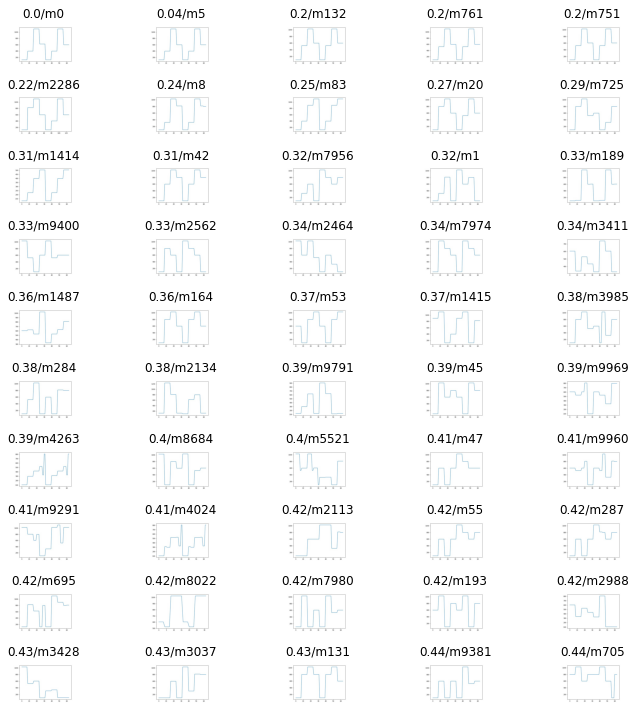

In [ ]:
# Insert the image query
img = Image.open("./Image_4_4_CT/img_0.jpg")
# Extract its features
query = fe.extract(img)

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis=1)

# Sort the images that have lowest distance
ids = np.argsort(dists)

scores_4_4_CT = [(dists[id], img_paths[id], uni_idx_4_4_CT[id]) for id in ids]

# Visualize the result
axes=[]
fig=plt.figure(figsize=(10,10))
for a in range(50): # 상위 50개만 추출
    score = scores_4_4_CT[a]
    axes.append(fig.add_subplot(10, 5, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

In [ ]:
imgs_4_4_CT = []
dissims_4_4_CT = []

for i in scores_4_4_CT:
  img = i[-1]
  dissim = i[0]
  imgs_4_4.append(img)
  dissims_4_4.append(dissim)

ct_4_4 = pd.DataFrame({'img':imgs_4_4_CT, 'score':dissims_4_4_CT}) 
ct_4_4['rank'] = ct_4_4['score'].rank(method = 'min')
ct_4_4

,img,score,rank
0,0,0.000000,1.0
1,5,0.038654,2.0
2,132,0.200209,3.0
3,761,0.200361,4.0
4,751,0.200609,5.0
...,...,...,...
236,41,0.793124,237.0
237,5498,0.807915,238.0
238,2097,0.811462,239.0
239,1411,0.815749,240.0


## 6/8 박자

### Signature 매핑

In [ ]:
features = []
img_paths = []
fe = FeatureExtractor()

# Save Image Feature Vector with Database Images
for i in uni_idx_6_8:
  try:
    image_path = "./Image_6_8/img_" + str(i) + ".jpg"
    img_paths.append(image_path)

    # Extract Features
    feature = fe.extract(img=Image.open(image_path))

    features.append(feature)

    # Save the Numpy array (.npy) on designated path
    feature_path = "./Image_6_8/m/img_" + str(i) + ".npy"
    np.save(feature_path, feature)
  except Exception as e:
    print('예외가 발생했습니다.', e)

1/1 [==============================] - 1s 584ms/step


1/1 [==============================] - 1s 1s/step


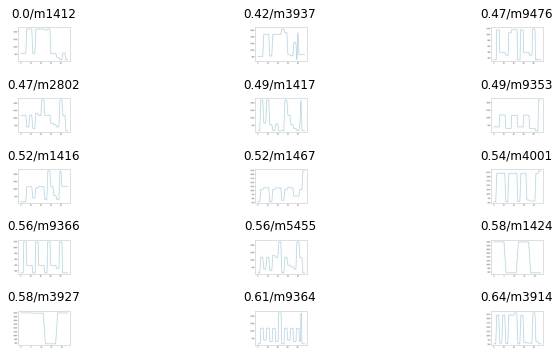

In [ ]:
# Insert the image query
img = Image.open("./Image_6_8/img_1412.jpg")
# Extract its features
query = fe.extract(img)

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis=1)

# Sort the id of images that have lowest distance
ids = np.argsort(dists)

scores_6_8 = [(dists[id], img_paths[id], uni_idx_6_8[id]) for id in ids]

# Visualize the result
axes=[]
fig=plt.figure(figsize=(10,10))
for a in range(len(uni_idx_6_8)):
    score = scores_6_8[a]
    axes.append(fig.add_subplot(10, 3, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

In [ ]:
imgs_6_8 = []
dissims_6_8 = []

for i in scores_6_8:
  img = i[-1]
  dissim = i[0]
  imgs_6_8.append(img)
  dissims_6_8.append(dissim)

cs_6_8 = pd.DataFrame({'img':imgs_6_8, 'score':dissims_6_8}) 
cs_6_8['rank'] = cs_6_8['score'].rank(method = 'min')
cs_6_8

,img,score,rank
0,0,0.000000,1.0
1,5,0.187504,2.0
2,5448,0.221715,3.0
3,15,0.255373,4.0
4,43,0.258407,5.0
...,...,...,...
236,86,0.757732,237.0
237,6251,0.759276,238.0
238,5498,0.771659,239.0
239,1750,0.772115,240.0


### 대안적 매핑

In [ ]:
features = []
img_paths = []
fe = FeatureExtractor()

# Save Image Feature Vector with Database Images
for i in uni_idx_6_8_CT:
  try:
    image_path = "./Image_6_8_CT/img_" + str(i) + ".jpg"
    img_paths.append(image_path)

    # Extract Features
    feature = fe.extract(img=Image.open(image_path))

    features.append(feature)

    # Save the Numpy array (.npy) on designated path
    feature_path = "./Image_6_8_CT/m/img_" + str(i) + ".npy"
    np.save(feature_path, feature)
  except Exception as e:
    print('예외가 발생했습니다.', e)

1/1 [==============================] - 1s 573ms/step


1/1 [==============================] - 1s 575ms/step


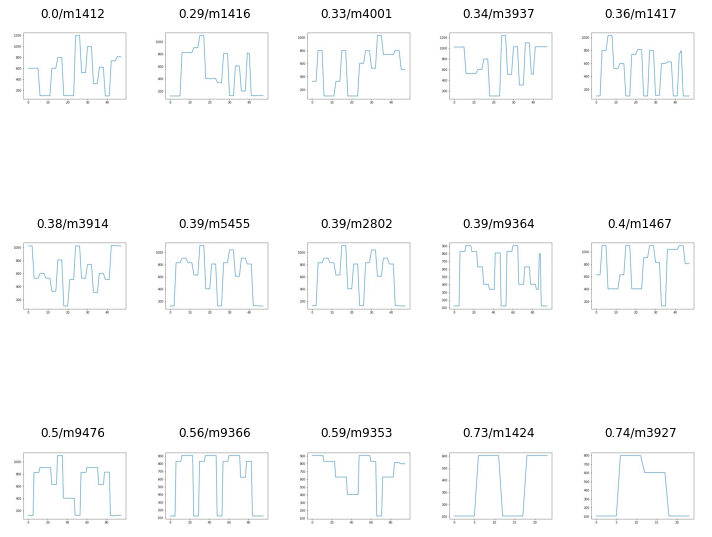

In [ ]:
# Insert the image query
img = Image.open("./Image_6_8_CT/img_1412.jpg")
# Extract its features
query = fe.extract(img)

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis=1)

# Sort the id of images that have lowest distance
ids = np.argsort(dists)

scores_6_8_CT = [(dists[id], img_paths[id], uni_idx_6_8_CT[id]) for id in ids]

# Visualize the result
axes=[]
fig=plt.figure(figsize=(10,10))
for a in range(len(uni_idx_6_8_CT)):
    score = scores_6_8_CT[a]
    axes.append(fig.add_subplot(3, 5, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

In [ ]:
imgs_6_8_CT = []
dissims_6_8_CT = []
for i in scores_6_8_CT:
  img = i[-1]
  dissim = i[0]
  imgs_6_8_CT.append(img)
  dissims_6_8_CT.append(dissim)

ct_6_8 = pd.DataFrame({'img':imgs_6_8_CT, 'score':dissims_6_8_CT}) 
ct_6_8['rank'] = ct_6_8['score'].rank(method = 'min')
ct_6_8

,img,score,rank
0,1412,0.000000,1.0
1,1416,0.290381,2.0
2,4001,0.331734,3.0
3,3937,0.340342,4.0
4,1417,0.359702,5.0
5,3914,0.375738,6.0
6,5455,0.387399,7.0
7,2802,0.388058,8.0
8,9364,0.394330,9.0
9,1467,0.402335,10.0


# 7. Signature 매핑과 대안적 매핑의 비교

## 3/4 박자

In [ ]:
# signature 매핑과 대안적 매핑의 거리와 순위를 비교하기 위해 signature 매핑을 기준으로 통합, 1순위는 항상 기준 이미지
result_3_4 = pd.merge(cs_3_4, ct_3_4, left_on = 'img', right_on = 'img', how = 'inner') 
result_3_4.head()

,img,score_x,rank_x,score_y,rank_y
0,2066,0.000000,1.0,0.000000,1.0
1,2093,0.243194,2.0,0.171169,2.0
2,8786,0.257315,3.0,0.602259,35.0
3,4859,0.295668,4.0,0.511681,27.0
4,8693,0.306511,5.0,0.477760,18.0


Text(0, 0.5, 'Rank of CT Progression')

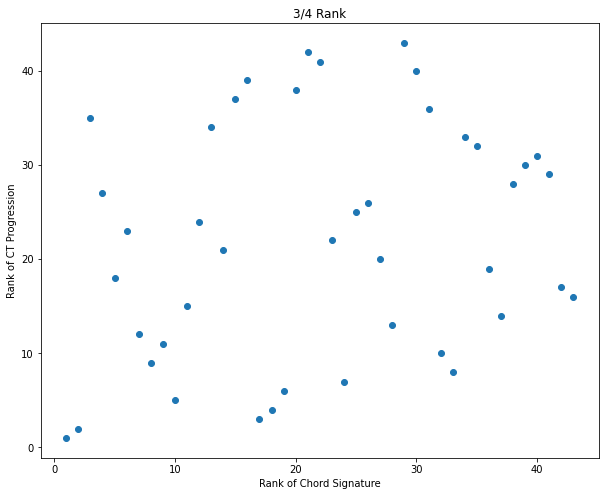

In [ ]:
# 두 개의 매핑 방식의 순위를 scatter plot으로 시각화
plt.figure(figsize = (10, 8))
plt.scatter(result_3_4.rank_x, result_3_4.rank_y)
plt.title('3/4 Rank')
plt.xlabel('Rank of Chord Signature')
plt.ylabel('Rank of CT Progression')

Text(0, 0.5, 'Score of CT Progression')

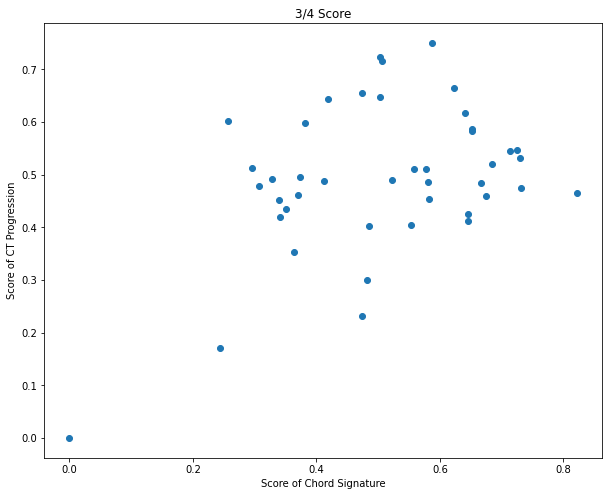

In [ ]:
# 두 개의 매핑 방식의 거리를 scatter plot으로 시각화
plt.figure(figsize = (10, 8))
plt.scatter(result_3_4.score_x, result_3_4.score_y)
plt.title('3/4 Score')
plt.xlabel('Score of Chord Signature')
plt.ylabel('Score of CT Progression')

## 4/4 박자

In [ ]:
# signature 매핑과 대안적 매핑의 거리와 순위를 비교하기 위해 signature 매핑을 기준으로 통합, 1순위는 항상 기준 이미지
result_4_4 = pd.merge(cs_4_4, ct_4_4, left_on = 'img', right_on = 'img', how = 'inner') 
result_4_4.head()

,img,score_x,rank_x,score_y,rank_y
0,0,0.000000,1.0,0.000000,1.0
1,5,0.187504,2.0,0.038654,2.0
2,5448,0.221715,3.0,0.480294,80.0
3,15,0.255373,4.0,0.490512,88.0
4,43,0.258407,5.0,0.500041,94.0


Text(0, 0.5, 'Rank of CT Progression')

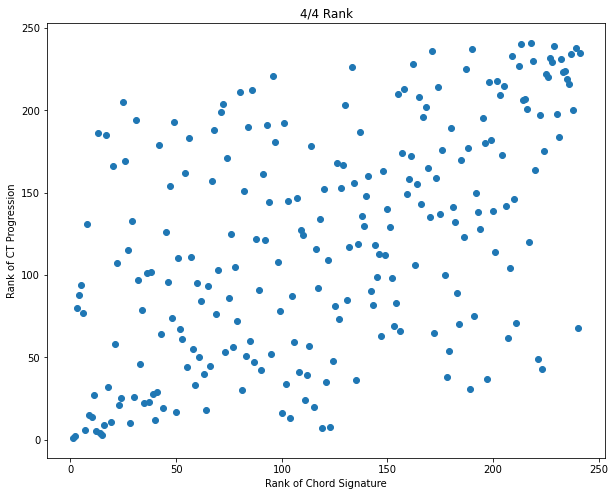

In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(result_4_4.rank_x, result_4_4.rank_y)
plt.title('4/4 Rank')
plt.xlabel('Rank of Chord Signature')
plt.ylabel('Rank of CT Progression')

Text(0, 0.5, 'Score of CT Progression')

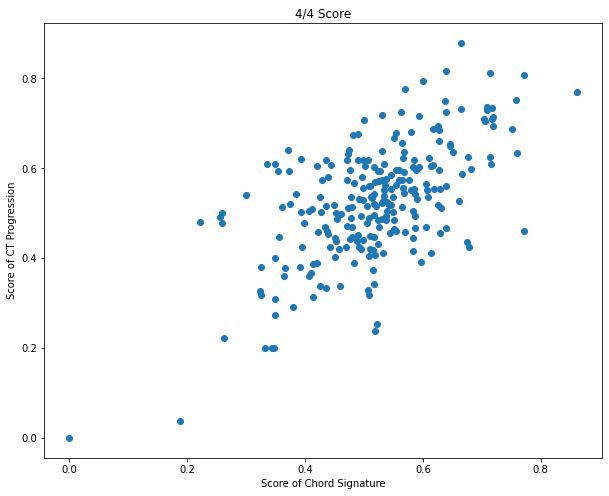

In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(result_4_4.score_x, result_4_4.score_y)
plt.title('4/4 Score')
plt.xlabel('Score of Chord Signature')
plt.ylabel('Score of CT Progression')

## 6/8 박자

In [ ]:
# signature 매핑과 대안적 매핑의 거리와 순위를 비교하기 위해 signature 매핑을 기준으로 통합, 1순위는 항상 기준 이미지
result_6_8 = pd.merge(cs_6_8, ct_6_8, left_on = 'img', right_on = 'img', how = 'inner') 
result_6_8.head()

,img,score_x,rank_x,score_y,rank_y
0,1412,0.000000,1.0,0.000000,1.0
1,3937,0.421069,2.0,0.340342,4.0
2,9476,0.468594,3.0,0.499990,11.0
3,2802,0.472541,4.0,0.388058,8.0
4,1417,0.488523,5.0,0.359702,5.0


Text(0, 0.5, 'Rank of CT Progression')

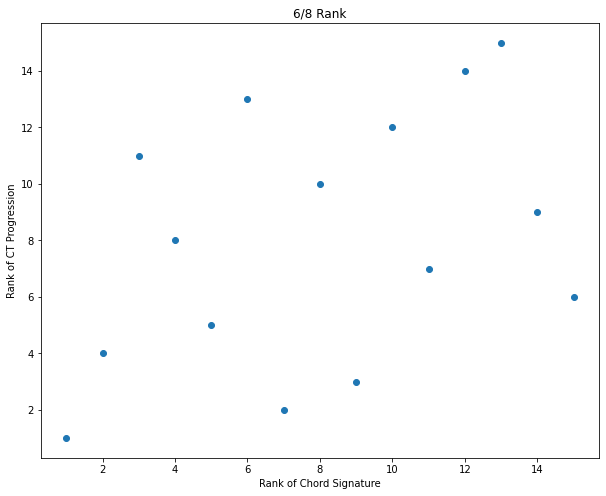

In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(result_6_8.rank_x, result_6_8.rank_y)
plt.title('6/8 Rank')
plt.xlabel('Rank of Chord Signature')
plt.ylabel('Rank of CT Progression')

Text(0, 0.5, 'Score of CT Progression')

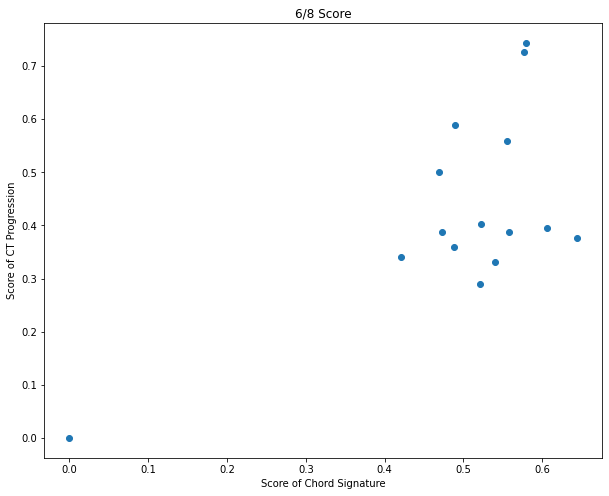

In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(result_6_8.score_x, result_6_8.score_y)
plt.title('6/8 Score')
plt.xlabel('Score of Chord Signature')
plt.ylabel('Score of CT Progression')